In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

In [2]:
#Import cleaned dataset

trips_df = pd.read_parquet('../../data/rides/Taxi_Trips_Sampled_Cleaned.parquet')
trips_df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,h3_07_dropoff,h3_08_pickup,h3_08_dropoff,h3_09_pickup,h3_09_dropoff,pickup_centroid,dropoff_centroid,datetime,temp,precip
0,1,2015-01-01 00:00:00,2015-01-01 00:00:00,540.0,0.17,17031080300,17031063301,8,6,7.25,...,872664c10ffffff,882664c13bfffff,882664c101fffff,892664c13afffff,892664c101bffff,POINT (-87.63576009 41.90749193),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
1,2,2015-01-01 00:00:00,2015-01-01 00:00:00,480.0,0.90,17031320100,17031081500,32,8,6.25,...,872664c1effffff,882664c1e3fffff,882664c1e1fffff,892664c1e2fffff,892664c1e0fffff,POINT (-87.620992913 41.884987192),POINT (-87.626214906 41.892507781),2015-01-01,-7.0115,0
2,3,2015-01-01 00:15:00,2015-01-01 00:30:00,780.0,5.50,17031281900,17031063301,28,6,14.05,...,872664c10ffffff,882664c1adfffff,882664c101fffff,892664c1acfffff,892664c101bffff,POINT (-87.642648998 41.879255084),POINT (-87.643022804 41.934539716),2015-01-01,-7.0115,0
3,4,2015-01-01 00:30:00,2015-01-01 00:45:00,780.0,2.30,17031062900,17031031400,6,3,8.85,...,872664d89ffffff,882664c163fffff,882664d893fffff,892664c162fffff,892664d8923ffff,POINT (-87.656411531 41.936237179),POINT (-87.645378762 41.962178629),2015-01-01,-7.0115,0
4,5,2015-01-01 00:00:00,2015-01-01 00:15:00,600.0,2.40,17031071500,17031070700,7,7,8.85,...,872664c12ffffff,882664c115fffff,882664c121fffff,892664c114fffff,892664c1257ffff,POINT (-87.631717366 41.914616286),POINT (-87.673807238 41.929272532),2015-01-01,-7.0115,0


In [3]:
#Simplify times to full hour
trips_df['start_time_hour'] = trips_df['trip_start_timestamp'].dt.floor('1H')
trips_df['end_time_hour'] = trips_df['trip_end_timestamp'].dt.floor('1H')

#Calculation of started and finished trips per hour
trips_starting = (trips_df.groupby(["start_time_hour"]).size().to_frame("trips_starting"))
trips_ending = (trips_df.groupby(["end_time_hour"]).size().to_frame("trips_ending"))

#Combine DFs and fill empty values
trips_hourly = pd.concat([trips_starting, trips_ending, ], axis=1)
trips_hourly = trips_hourly.fillna(0)

#Calculate difference of trips
trips_hourly['trips_diff'] = trips_hourly['trips_starting'] - trips_hourly['trips_ending']
trips_hourly['trips_active'] = trips_hourly['trips_diff'].cumsum()
trips_hourly['trips_prev_active'] = trips_hourly['trips_active'].shift(1)

#Keep only relevant features
trips_hourly = trips_hourly[['trips_starting', 'trips_prev_active']]

#Remove unavailable entries
trips_hourly = trips_hourly.dropna()

trips_hourly["ongoing_trips"] = trips_hourly["trips_starting"] + trips_hourly["trips_prev_active"]

trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week
trips_hourly['month'] = trips_hourly.index.month

trips_hourly


,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week,month
2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,1
2015-01-01 02:00:00,91.0,22.0,113.0,1,2,3,1
2015-01-01 03:00:00,57.0,18.0,75.0,1,3,3,1
2015-01-01 04:00:00,17.0,6.0,23.0,1,4,3,1
2015-01-01 05:00:00,3.0,1.0,4.0,1,5,3,1
...,...,...,...,...,...,...,...
2015-12-31 08:00:00,8.0,2.0,10.0,365,8,3,12
2015-12-31 09:00:00,8.0,3.0,11.0,365,9,3,12
2015-12-31 10:00:00,8.0,2.0,10.0,365,10,3,12
2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3,12


In [4]:
# Create a copy of the 'trips_df' DataFrame and set the floored datetime as the index
trips_df_copy = trips_df.copy()
trips_df_copy.set_index(trips_df_copy['trip_start_timestamp'].dt.floor('H'), inplace=True)

# Select the relevant columns from 'trips_df_copy' to merge into 'trips_hourly'
precip_columns = ['precip']

# Create a new DataFrame with only the relevant columns from 'trips_df_copy'
precip_data = trips_df_copy[precip_columns]

# Merge 'precip_data' into 'trips_hourly' based on the datetime index
trips_hourly_with_precip = trips_hourly.merge(precip_data, left_index=True, right_index=True, how='left')
trips_hourly_with_precip = trips_hourly_with_precip.reset_index()

trips_hourly_with_precip = trips_hourly_with_precip.drop_duplicates(subset=['index'])

trips_hourly_with_precip

,index,trips_starting,trips_prev_active,ongoing_trips,day_of_year,hour,day_of_week,month,precip
0,2015-01-01 01:00:00,70.0,8.0,78.0,1,1,3,1,0.0
70,2015-01-01 02:00:00,91.0,22.0,113.0,1,2,3,1,0.0
161,2015-01-01 03:00:00,57.0,18.0,75.0,1,3,3,1,0.0
218,2015-01-01 04:00:00,17.0,6.0,23.0,1,4,3,1,0.0
235,2015-01-01 05:00:00,3.0,1.0,4.0,1,5,3,1,0.0
...,...,...,...,...,...,...,...,...,...
170558,2015-12-31 08:00:00,8.0,2.0,10.0,365,8,3,12,0.0
170566,2015-12-31 09:00:00,8.0,3.0,11.0,365,9,3,12,0.0
170574,2015-12-31 10:00:00,8.0,2.0,10.0,365,10,3,12,0.0
170582,2015-12-31 11:00:00,15.0,0.0,15.0,365,11,3,12,0.0


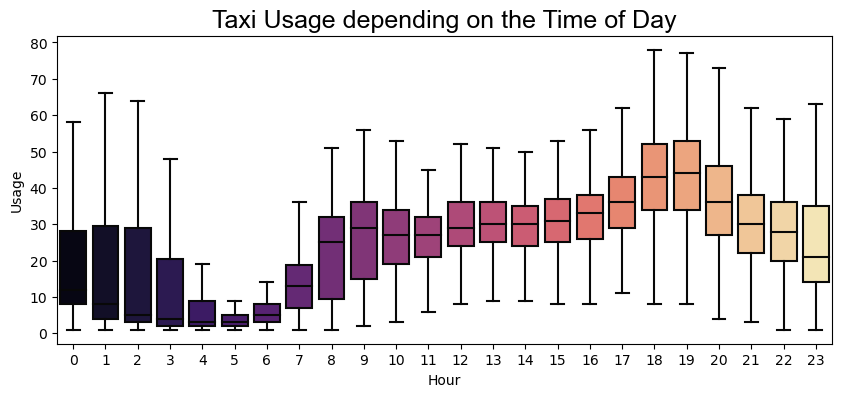

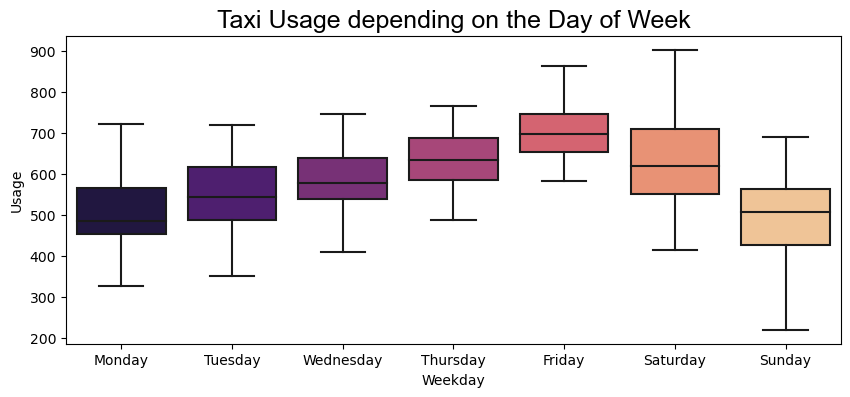

In [5]:
trips_hourly_hour = trips_hourly.groupby(["day_of_year","hour"])["ongoing_trips"].sum()
trips_hourly_hour = pd.DataFrame(trips_hourly_hour)
hour=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

fig, ax1 = plt.subplots(figsize=(10, 4))
sns.boxplot(x=trips_hourly_hour.index.get_level_values(1), y=trips_hourly_hour["ongoing_trips"], ax=ax1, palette="magma", showfliers=False)
ax1.set_title("Taxi Usage depending on the Time of Day", fontsize=18, fontname="Arial")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Usage")
ax1.set_xticklabels(hour)



weekday=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
trips_hourly_week = trips_hourly.groupby(["day_of_year","day_of_week"])["ongoing_trips"].sum()
trips_hourly_week = pd.DataFrame(trips_hourly_week)

fig, ax2 = plt.subplots(figsize=(10, 4))
sns.boxplot(x=trips_hourly_week.index.get_level_values(1), y=trips_hourly_week["ongoing_trips"], ax=ax2, palette="magma", showfliers=False)
ax2.set_title("Taxi Usage depending on the Day of Week", fontsize=18, fontname="Arial")
ax2.set_xlabel("Weekday")
ax2.set_ylabel("Usage")
ax2.set_xticklabels(weekday)
plt.show()


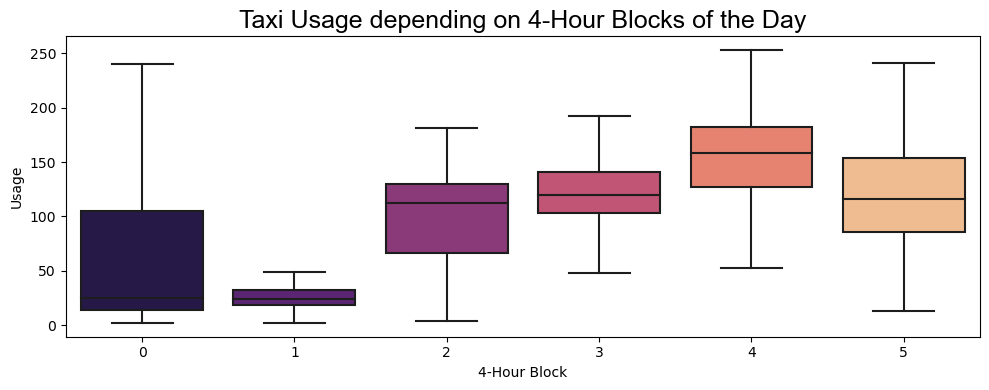

In [6]:
# Create a new column for the 4-hour blocks
trips_hourly['4_hour_block'] = trips_hourly['hour'] // 4

# Group by the new 4-hour block column and aggregate the data
trips_hourly_block = trips_hourly.groupby(['day_of_year', '4_hour_block'])[['trips_starting', 'trips_prev_active', 'ongoing_trips']].sum().reset_index()

# Displaying values graphically
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=trips_hourly_block['4_hour_block'], y=trips_hourly_block['ongoing_trips'], ax=ax, palette='magma', showfliers=False)
ax.set_title('Taxi Usage depending on 4-Hour Blocks of the Day', fontsize=18, fontname='Arial')
ax.set_xlabel('4-Hour Block')
ax.set_ylabel('Usage')
plt.tight_layout()
plt.show()


In [7]:
################# Why is number of ongoing trips higher than the size of our datadrame (171339)? ###############
print(trips_hourly_hour['ongoing_trips'].sum())
trips_hourly_hour

hour_1_data = trips_hourly_hour[trips_hourly_hour.index.get_level_values('hour') == 1]

sum_ongoing_trips_hour_1 = hour_1_data['ongoing_trips'].sum()

print("Total ongoing trips for hour==1:", sum_ongoing_trips_hour_1)

210853.0
Total ongoing trips for hour==1: 5973.0


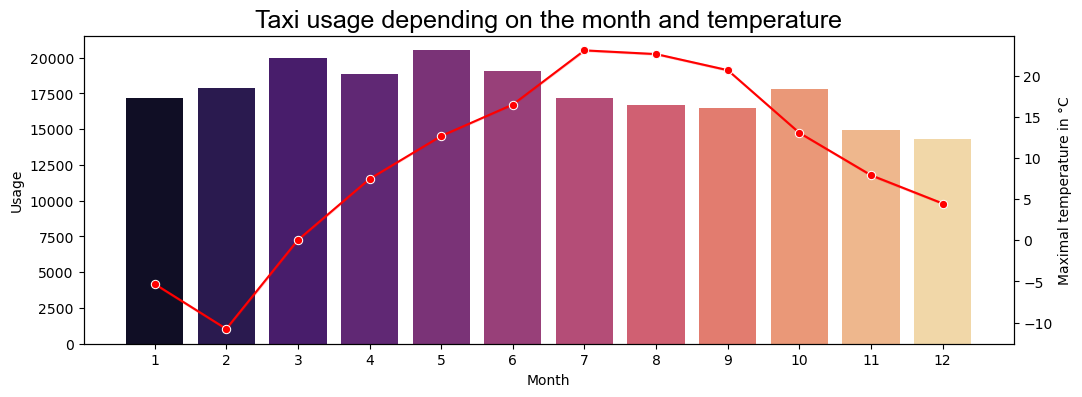

In [8]:
trips_monthly = trips_hourly.groupby(["month"])["ongoing_trips"].sum().reset_index()
trips_monthly = pd.DataFrame(trips_monthly)

fig,ax = plt.subplots(figsize=(12,4)) 
sns.barplot(data=trips_monthly, x="month", y="ongoing_trips", palette="magma", ax=ax)
ax.set_title("Taxi usage depending on the month and temperature", fontsize=18, fontname="Arial")
ax.set_xlabel("Month")
ax.set_ylabel("Usage")

ax2 = ax.twinx()
# month start -1 to fit it to the taxi usage 
sns.lineplot(x=(trips_df["month_start"]-1), y=trips_df["temp"], ax=ax2, color='red', marker='o')
ax2.set_ylabel("Maximal temperature in °C")
ax.yaxis.grid(False)

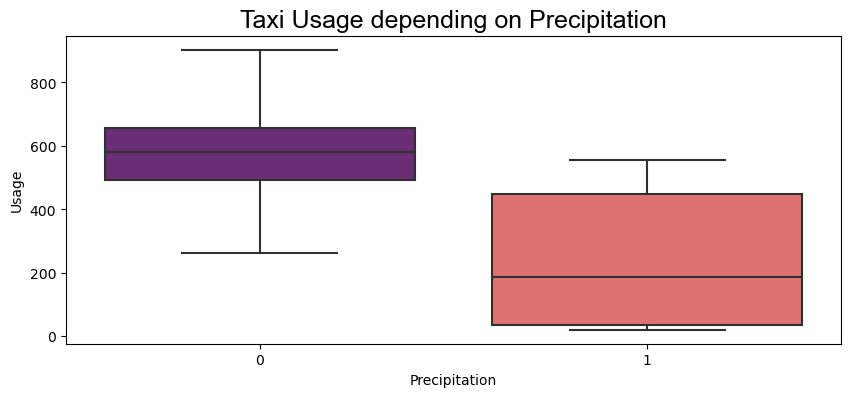

In [9]:

#group by precipitation and plot
trips_precip = trips_hourly_with_precip.groupby(["day_of_year","precip"])["ongoing_trips"].sum()
trips_precip = pd.DataFrame(trips_precip)

fig,ax = plt.subplots(figsize=(10,4)) 

sns.boxplot(x=trips_precip.index.get_level_values(1), y=trips_precip["ongoing_trips"],ax=ax, palette="magma", showfliers=False)
ax.set_title("Taxi Usage depending on Precipitation", fontsize=18, fontname="Arial")
ax.set_xlabel("Precipitation")
ax.set_ylabel("Usage")


ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()

In [10]:
trips_precip = trips_precip.reset_index()

precip_count = (trips_precip['precip'] == 1.0).sum()
non_precip_count = (trips_precip['precip'] == 0.0).sum()

ratio = precip_count / non_precip_count

In [14]:
######### Hier aufzeigen, dass es in Chicago generell kaum regnet, weshalb die Werte darüber zeigen, dass es mehr Taxifahrten ohen Regen gibt (ander als unsere Erwartung)
categories = ['Precip', 'Non Precip']
values = [precip_count, non_precip_count]

fig = px.pie(
    names=categories,
    values=values,
    title='Ratio of Precipitation to No Precipitation',
    color_discrete_sequence=["#4B2991","#F6A97A"]
)

fig.show()


### Price analysis

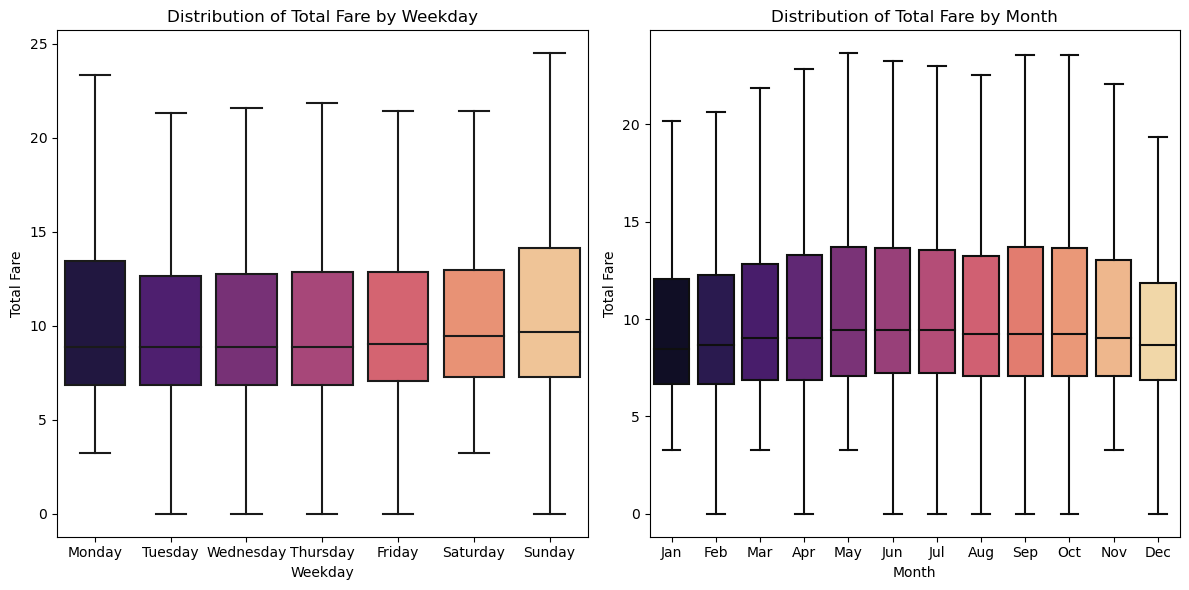

In [12]:
plt.figure(figsize=(12, 6))

# Boxplot for weekday
plt.subplot(1, 2, 1)
sns.boxplot(data=trips_df, x="dayofweek_start", y="trip_total", palette="magma", showfliers=False)
plt.title("Distribution of Total Fare by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Total Fare")
plt.xticks(range(7), weekday)

# Boxplot for month
plt.subplot(1, 2, 2)
sns.boxplot(data=trips_df, x="month_start", y="trip_total", palette="magma", showfliers=False)
plt.title("Distribution of Total Fare by Month")
plt.xlabel("Month")
plt.ylabel("Total Fare")
plt.xticks(range(0, 12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

plt.tight_layout()
plt.show()


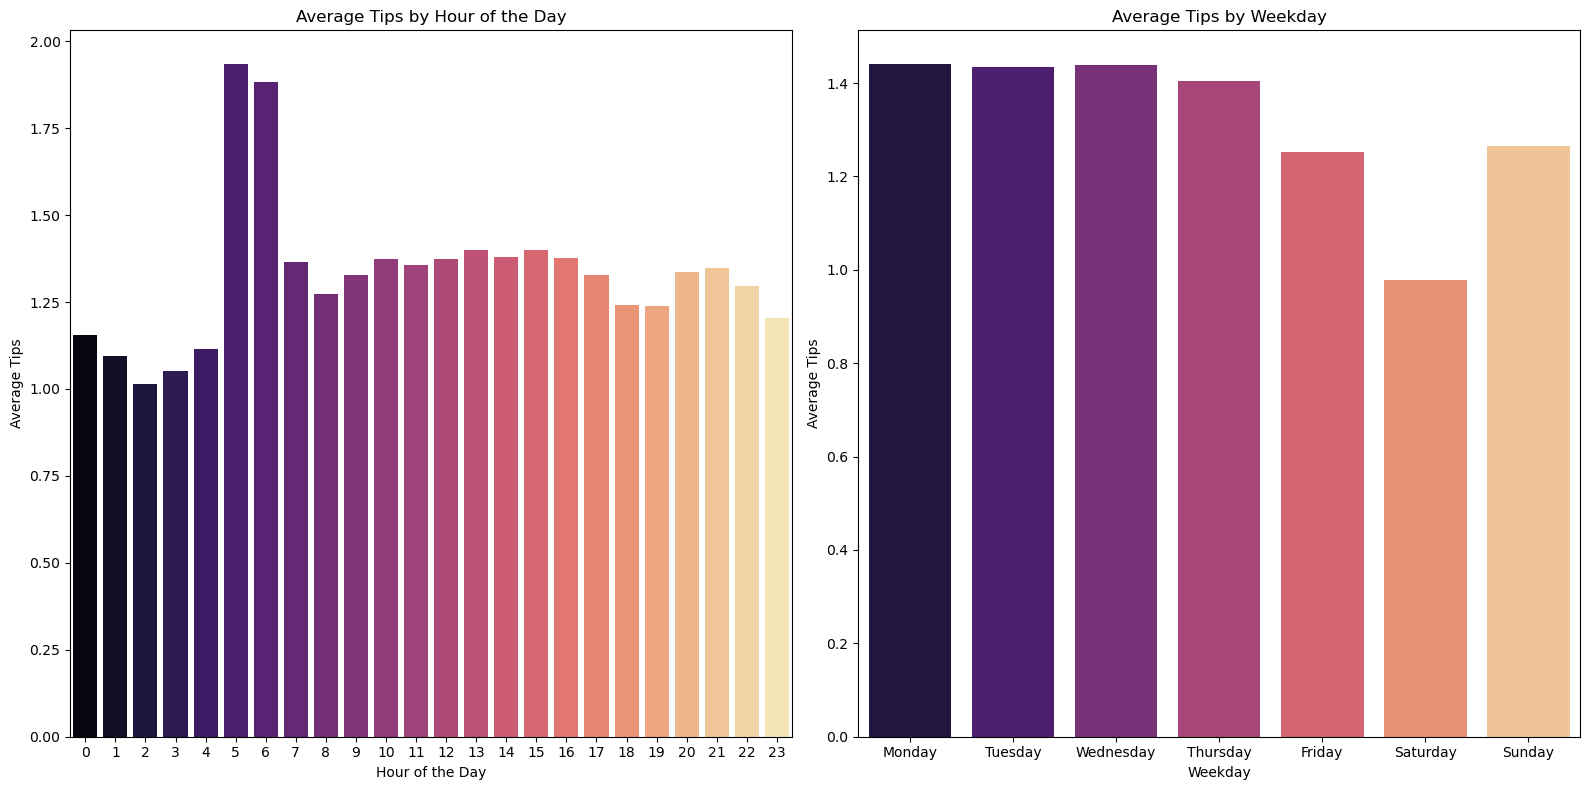

In [13]:
plt.figure(figsize=(16, 8))
# Group by hour and calculate the average of tips for each hour
tips_by_hour = trips_df.groupby('hour_end')['tips'].mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x='hour_end', y='tips', palette="magma", data=tips_by_hour)
plt.xlabel('Hour of the Day')
plt.ylabel('Average Tips')
plt.title('Average Tips by Hour of the Day')

# Group by weekday and calculate the average of tips for each weekday
tips_by_weekday = trips_df.groupby('dayofweek_end')['tips'].mean().reset_index()

# Create a bar plot for average tips by weekday
plt.subplot(1, 2, 2)
sns.barplot(x='dayofweek_end', y='tips', palette="magma", data=tips_by_weekday)
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Weekday')
plt.ylabel('Average Tips')
plt.title('Average Tips by Weekday')

plt.tight_layout()
plt.show()
